## Collect

Na EximiaCo, acreditamos que o "código" é a principal fonte da verdade. Por isso, valorizamos dados extraídos do código fonte.

Nesse exercício, coletamos informações com relação ao volume de modificações (changes) dos arquivos de um repositório GIT na máquina local. 

Consideramos os últimos três meses de modificações porque entendemos que essa é uma janela relevante para mostrar o "momento do time"

In [4]:
! pip install GitPython --quiet

In [5]:
import git
from datetime import datetime, timedelta

def get_commits_last_three_months(repo_path, branch_name):
    # Inicializar o repositório
    repo = git.Repo(repo_path)

    # Calcular a data de três meses atrás
    three_months_ago = datetime.now() - timedelta(days=90)
    
    # Lista para armazenar os commits
    commits = []

    # Iterar sobre os commits na branch especificada
    for commit in repo.iter_commits(branch_name, since=three_months_ago.isoformat()):
        for file_stat in commit.stats.files.items():
            file_name, stats = file_stat
            commit_info = {
                'sha': commit.hexsha,
                'author': commit.author.name,
                'file': file_name,
                'changes': stats['insertions'] + stats['deletions']
            }
            commits.append(commit_info)
            
    return commits

In [6]:
commits = get_commits_last_three_months("~/Documents/GitHub/ravendb", "v6.0")

In [7]:
len(commits)

6956

In [8]:
! pip install pandas --quiet

In [9]:
import pandas as pd

In [10]:
commits_df = pd.DataFrame(commits)
commits_df.head()

,sha,author,file,changes
0,99fe8133164d9d09f0f7f66891d890ab3c0d5b9e,Arkadiusz Palinski,test/SlowTests/Sharding/Backup/ShardedBackupTe...,9
1,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Raven.Server/Documents/Indexes/MapReduce/M...,7
2,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.MultiTree.cs,7
3,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.Stream.cs,7
4,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.cs,2


In [11]:
commits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sha      6956 non-null   object
 1   author   6956 non-null   object
 2   file     6956 non-null   object
 3   changes  6956 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 217.5+ KB


## Organize

O próximo passo é agrupar as informações de forma a gerar insights relevantes.

Quando analisamos o volume de alterações em um repositório, é importante analisar tanto a quantidade de changes por arquivo, para identificar quais são os arquivos mais modificados, como também o volume de changes por autor. Dessa forma, entendemos quem são os desenvolvedores com maior relevância no time, pelo menos na história recente.

In [14]:
summary_per_file = commits_df.groupby('file')['changes'].sum().reset_index()

# Ordenar o resultado para ver os arquivos com mais mudanças primeiro
summary_per_file_sorted = summary_per_file.sort_values(by='changes', ascending=False)

# Exibir os resultados
summary_per_file_sorted.head(10)

,file,changes
564,src/Raven.Studio/package-lock.json,311855
1700,test/SlowTests/Server/Documents/PeriodicBackup...,3681
1055,src/Raven.Studio/typescript/components/pages/r...,2718
1037,src/Raven.Studio/typescript/components/pages/r...,2619
1315,src/Sparrow/Memory.cs,1816
1154,src/Raven.Studio/typescript/viewmodels/databas...,1810
1535,test/SlowTests/Issues/RavenDB-19922.cs,1766
1454,test/SlowTests/Client/Subscriptions/Concurrent...,1695
796,src/Raven.Studio/typescript/components/common/...,1605
1733,test/SlowTests/SparrowTests/ModifyConfiguratio...,1508


Eventualmente, já na primeira análise, identifica-se algum desvio. Por exemplo, coleta de arquivos que não são relevantes para a análise. 

O ideal, durante a organização, é promover a limpeza dos dados.

In [16]:
filtered_commits_df = commits_df.loc[commits_df['file'] != 'src/Raven.Studio/package-lock.json']
summary_per_file = filtered_commits_df.groupby('file')['changes'].sum().reset_index()
summary_per_file_sorted = summary_per_file.sort_values(by='changes', ascending=False)
summary_per_file_sorted.head(10)

,file,changes
1699,test/SlowTests/Server/Documents/PeriodicBackup...,3681
1054,src/Raven.Studio/typescript/components/pages/r...,2718
1036,src/Raven.Studio/typescript/components/pages/r...,2619
1314,src/Sparrow/Memory.cs,1816
1153,src/Raven.Studio/typescript/viewmodels/databas...,1810
1534,test/SlowTests/Issues/RavenDB-19922.cs,1766
1453,test/SlowTests/Client/Subscriptions/Concurrent...,1695
795,src/Raven.Studio/typescript/components/common/...,1605
1732,test/SlowTests/SparrowTests/ModifyConfiguratio...,1508
1040,src/Raven.Studio/typescript/components/pages/r...,1432


In [17]:
summary_per_author = filtered_commits_df.groupby('author')['changes'].sum().reset_index()
summary_per_author_sorted = summary_per_author.sort_values(by='changes', ascending=False)
summary_per_author_sorted

,author,changes
3,Damian Olszewski,48448
1,Arkadiusz Paliński,31428
0,Arkadiusz Palinski,28402
17,Paweł Pekról,24876
4,Federico Lois,7070
11,Maciej Aszyk,6193
26,shaharhikri,4912
14,Mateusz,4012
15,Michał Leśniak,3018
16,Pawel Pekrol,2772


Outras vezes, também, é possível identificar nos dados algumas inconsistências, como, por exemplo, aqui, autores que aparecem na lista como diferentes, mas são a mesma pessoa.

O ideal, também, é consolidar a lista.

In [19]:
sorted(commits_df['author'].unique())

['Arkadiusz Palinski',
 'Arkadiusz Paliński',
 'Bartosz Piekarski',
 'Damian Olszewski',
 'Federico Lois',
 'Gracjan Sadowicz',
 'Grisha Kotler',
 'Igal Merhavia',
 'James Thompson',
 'Karmel Indych',
 'Lev Skuditsky',
 'Maciej Aszyk',
 'Marcin Lewandowski',
 'Marko Lahma',
 'Mateusz',
 'Michał Leśniak',
 'Pawel Pekrol',
 'Paweł Pekról',
 'Rafal Kwiatkowski',
 'Stav Lagziel',
 'aviv',
 'danielle9897',
 'dependabot[bot]',
 'efrat@ravendb.net',
 'egor',
 'mateuszbartosik',
 'ravendb-bot',
 'shaharhikri',
 'shiranshalom',
 'unknown']

In [20]:
commits_df['author'] = commits_df['author'].replace('Arkadiusz Palinski', 'Arkadiusz Paliński')
commits_df['author'] = commits_df['author'].replace('Pawel Pekrol', 'Paweł Pekról')
commits_df['author'] = commits_df['author'].replace('Mateusz', 'Mateusz Bartosik')
commits_df['author'] = commits_df['author'].replace('mateuszbartosik', 'Mateusz Bartosik')
sorted(commits_df['author'].unique())

['Arkadiusz Paliński',
 'Bartosz Piekarski',
 'Damian Olszewski',
 'Federico Lois',
 'Gracjan Sadowicz',
 'Grisha Kotler',
 'Igal Merhavia',
 'James Thompson',
 'Karmel Indych',
 'Lev Skuditsky',
 'Maciej Aszyk',
 'Marcin Lewandowski',
 'Marko Lahma',
 'Mateusz Bartosik',
 'Michał Leśniak',
 'Paweł Pekról',
 'Rafal Kwiatkowski',
 'Stav Lagziel',
 'aviv',
 'danielle9897',
 'dependabot[bot]',
 'efrat@ravendb.net',
 'egor',
 'ravendb-bot',
 'shaharhikri',
 'shiranshalom',
 'unknown']

In [21]:
filtered_commits_df = commits_df.loc[commits_df['file'] != 'src/Raven.Studio/package-lock.json']
summary_per_author = filtered_commits_df.groupby('author')['changes'].sum().reset_index()
summary_per_author_sorted = summary_per_author.sort_values(by='changes', ascending=False)
summary_per_author_sorted

,author,changes
0,Arkadiusz Paliński,59830
2,Damian Olszewski,48448
15,Paweł Pekról,27648
3,Federico Lois,7070
10,Maciej Aszyk,6193
23,shaharhikri,4912
13,Mateusz Bartosik,4042
14,Michał Leśniak,3018
20,efrat@ravendb.net,2697
24,shiranshalom,2626


Eventualmente, os dados levantados podem ser analisados em uma ferramenta externa, como o Excel.

In [23]:
commits_df.to_csv('data.csv', sep=';')

## Distill

Concluída a organização, é hora de começar a explorar os dados para, com base na experiência, coletar alguns insights.

In [26]:
summary_per_file_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1848 entries, 1699 to 1497
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     1848 non-null   object
 1   changes  1848 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.3+ KB


É sempre bom gerar gráficos que autorizem uma análise visual dos dados.

In [28]:
! pip install matplotlib seaborn --quiet

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


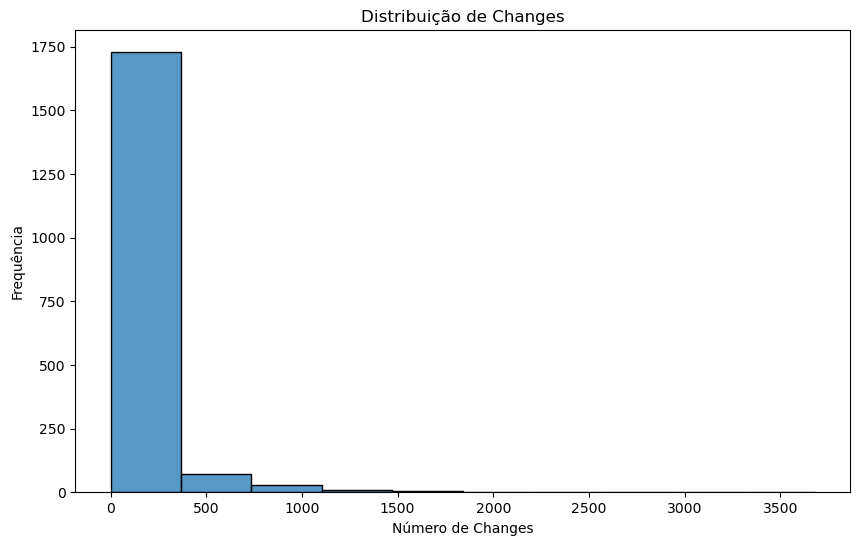

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(summary_per_file_sorted['changes'], bins=10, kde=False)
plt.title('Distribuição de Changes')
plt.xlabel('Número de Changes')
plt.ylabel('Frequência')
plt.show()

In [31]:
! pip install numpy --quiet

In [32]:
import numpy as np

data = summary_per_file_sorted['changes']

# Calcular histograma
counts, bin_edges = np.histogram(data, bins=10)

# Criar DataFrame a partir dos resultados do histograma
hist_df = pd.DataFrame({'Bin Min': [bin_edges[i] for i in range(len(bin_edges)-1)],
                        'Bin Max': [bin_edges[i+1] for i in range(len(bin_edges)-1)], 
                        'Frequency': counts})

hist_df

,Bin Min,Bin Max,Frequency
0,0.0,368.1,1729
1,368.1,736.2,73
2,736.2,1104.3,27
3,1104.3,1472.4,10
4,1472.4,1840.5,6
5,1840.5,2208.6,0
6,2208.6,2576.7,0
7,2576.7,2944.8,2
8,2944.8,3312.9,0
9,3312.9,3681.0,1


In [33]:
def get_files(bin_min, bin_max):
     return summary_per_file_sorted[ 
        (summary_per_file_sorted['changes'] >= bin_min) & 
        (summary_per_file_sorted['changes'] <= bin_max)
     ].copy()

In [34]:
most_modified_files = get_files(1104, 3681)
most_modified_files

,file,changes
1699,test/SlowTests/Server/Documents/PeriodicBackup...,3681
1054,src/Raven.Studio/typescript/components/pages/r...,2718
1036,src/Raven.Studio/typescript/components/pages/r...,2619
1314,src/Sparrow/Memory.cs,1816
1153,src/Raven.Studio/typescript/viewmodels/databas...,1810
1534,test/SlowTests/Issues/RavenDB-19922.cs,1766
1453,test/SlowTests/Client/Subscriptions/Concurrent...,1695
795,src/Raven.Studio/typescript/components/common/...,1605
1732,test/SlowTests/SparrowTests/ModifyConfiguratio...,1508
1040,src/Raven.Studio/typescript/components/pages/r...,1432


In [35]:
most_modified_files['changes'].sum()

31665

In [36]:
total_changes = summary_per_file_sorted['changes'].sum()

In [37]:
most_modified_files['perc']= (most_modified_files['changes'] / total_changes * 100)

In [38]:
most_modified_files

,file,changes,perc
1699,test/SlowTests/Server/Documents/PeriodicBackup...,3681,2.054817
1054,src/Raven.Studio/typescript/components/pages/r...,2718,1.517249
1036,src/Raven.Studio/typescript/components/pages/r...,2619,1.461985
1314,src/Sparrow/Memory.cs,1816,1.013732
1153,src/Raven.Studio/typescript/viewmodels/databas...,1810,1.010383
1534,test/SlowTests/Issues/RavenDB-19922.cs,1766,0.985821
1453,test/SlowTests/Client/Subscriptions/Concurrent...,1695,0.946187
795,src/Raven.Studio/typescript/components/common/...,1605,0.895947
1732,test/SlowTests/SparrowTests/ModifyConfiguratio...,1508,0.841800
1040,src/Raven.Studio/typescript/components/pages/r...,1432,0.799375


In [39]:
most_modified_files['perc'].sum()

17.676119236351457

In [40]:
list(most_modified_files['file'])

['test/SlowTests/Server/Documents/PeriodicBackup/PeriodicBackupSlowTests.cs',
 'src/Raven.Studio/typescript/components/pages/resources/databases/partials/create/regular/CreateDatabaseRegular.tsx',
 'src/Raven.Studio/typescript/components/pages/resources/databases/partials/create/formBackup/CreateDatabaseFromBackup.tsx',
 'src/Sparrow/Memory.cs',
 'src/Raven.Studio/typescript/viewmodels/database/settings/connectionStrings.ts',
 'test/SlowTests/Issues/RavenDB-19922.cs',
 'test/SlowTests/Client/Subscriptions/ConcurrentSubscriptionsTests.cs',
 'src/Raven.Studio/typescript/components/common/CreateDatabase.tsx',
 'test/SlowTests/SparrowTests/ModifyConfigurationTests.cs',
 'src/Raven.Studio/typescript/components/pages/resources/databases/partials/create/formBackup/steps/CreateDatabaseFromBackupStepSource.tsx',
 'test/SlowTests/Issues/RavenDB-19951.cs',
 'src/Raven.Studio/typescript/components/pages/database/settings/connectionStrings/editForms/ElasticSearchConnectionString.tsx',
 'src/Raven.S

In [41]:
len(most_modified_files) / len(summary_per_file) * 100

1.0281385281385282

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


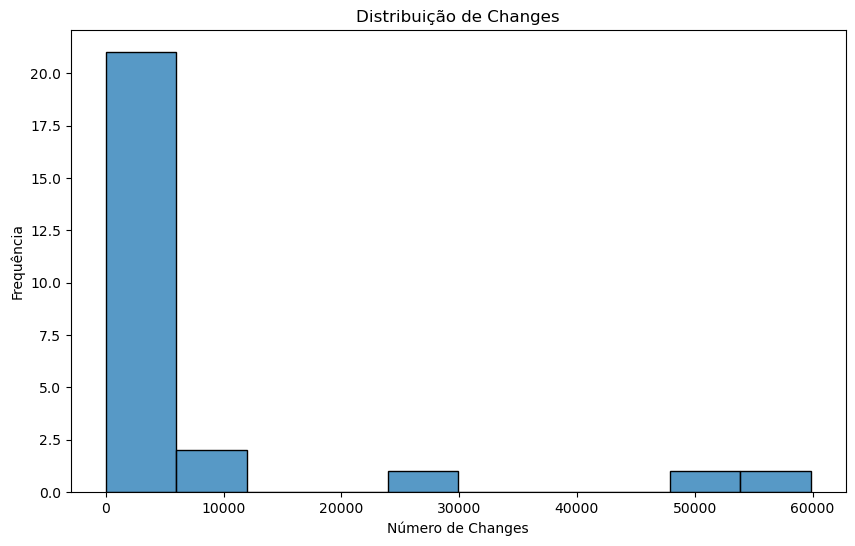

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(summary_per_author_sorted['changes'], bins=10, kde=False)
plt.title('Distribuição de Changes')
plt.xlabel('Número de Changes')
plt.ylabel('Frequência')
plt.show()

In [43]:
data = summary_per_author_sorted['changes']

# Calcular histograma
counts, bin_edges = np.histogram(data, bins=10)

# Criar DataFrame a partir dos resultados do histograma
hist_df = pd.DataFrame({'Bin Min': [bin_edges[i] for i in range(len(bin_edges)-1)],
                        'Bin Max': [bin_edges[i+1] for i in range(len(bin_edges)-1)], 
                        'Frequency': counts})

hist_df

,Bin Min,Bin Max,Frequency
0,14.0,5995.6,21
1,5995.6,11977.2,2
2,11977.2,17958.8,0
3,17958.8,23940.4,0
4,23940.4,29922.0,1
5,29922.0,35903.6,0
6,35903.6,41885.2,0
7,41885.2,47866.8,0
8,47866.8,53848.4,1
9,53848.4,59830.0,1


In [44]:
d = summary_per_author_sorted.copy()
d['perc'] = d['changes'] / total_changes * 100
d

,author,changes,perc
0,Arkadiusz Paliński,59830,33.398459
2,Damian Olszewski,48448,27.044769
15,Paweł Pekról,27648,15.433739
3,Federico Lois,7070,3.946634
10,Maciej Aszyk,6193,3.457073
23,shaharhikri,4912,2.741990
13,Mateusz Bartosik,4042,2.256336
14,Michał Leśniak,3018,1.684716
20,efrat@ravendb.net,2697,1.505526
24,shiranshalom,2626,1.465893


## Express

Concluídas as análises, é bom ter um resumo consolidado de quais são as principais conclusões. Que podem direcionar a ações.

Pouco mais de 1% dos arquivos representa 7% das alterações nos últimos três meses.

```test/SlowTests/Server/Documents/PeriodicBackup/PeriodicBackupSlowTests.cs```, sozinho, representa mais de 2% das modificações.

60% das modificações foram feitas por dois membros do time: Arkadiusz e Damian